<img src = 'Image/poems.jpg' width = '2000' height = '1500'>

# Poetry Generator - Business Problem

---


A poetry generator is a sophisticated tool or program that leverages the power of algorithms and natural language processing to automatically generate poetry. It takes user-provided inputs such as keywords, themes, or prompts, and seamlessly transforms them into evocative lines of poetry. This tool is designed to be highly customizable, allowing users to personalize the poetry generation process by adjusting factors such as rhyme schemes, meter, and other literary elements to suit their specific needs. 

Whether you're a content creator seeking inspiration, an educator looking to teach the art of poetry, or a marketer or advertiser looking to add a unique and engaging touch to your campaigns, our poetry generator is the perfect solution. With its ability to generate unique and captivating poetry, it can give your campaign the edge it needs to stand out in today's crowded market.

The objective of this project is to develop a tool that enables content creators, marketers, and advertisers to generate unique and engaging poetry for use in their campaigns and marketing materials. With the growing need for creative and personalized content, a poetry generator can save time and resources for these professionals while also giving them a competitive edge in a crowded market.

# Poetry Generator - Dataset

Our project utilizes the Gutenberg Poetry corpus, a comprehensive collection of poetry comprising of approximately three million lines sourced from hundreds of books from Project Gutenberg. This corpus was expertly curated and processed by Allison Parrish, making it an ideal dataset for applications in creative computational poetic text generation. 

By accessing this dataset through the link https://github.com/aparrish/gutenberg-poetry-corpus, we aim to harness the wealth of poetry within it and use advanced algorithms and natural language processing techniques to generate new, unique, and captivating poetry. The end result of this project will be a cutting-edge poetry generator tool that will assist content creators, marketers, and advertisers in producing unique and engaging poetry for their campaigns and marketing materials, allowing them to stand out in a crowded market.

## Dataset Inspection

In [1]:
!ls Data

Gutenberg-Poetry.csv         kaggle_poem_dataset.csv
gutenberg-poetry-v001.ndjson


In [2]:
import pandas as pd
import nltk
import string
import tensorflow as tf
from nltk.tokenize import word_tokenize

from tensorflow import keras
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import matplotlib.pyplot as plt

import spacy
from collections import Counter
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

import networkx as nx
from tensorflow.keras.utils import to_categorical
import re
from nltk.corpus import cmudict
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

In [3]:
df = pd.read_csv('Data/kaggle_poem_dataset.csv', index_col = 'Unnamed: 0')
df.head()

,Author,Title,Poetry Foundation ID,Content
0,Wendy Videlock,!,55489,"Dear Writers, I’m compiling the first in what ..."
1,Hailey Leithauser,0,41729,"Philosophic\nin its complex, ovoid emptiness,\..."
2,Jody Gladding,1-800-FEAR,57135,We'd like to talk with you about fear t...
3,Joseph Brodsky,1 January 1965,56736,The Wise Men will unlearn your name.\nAbove yo...
4,Ted Berrigan,3 Pages,51624,For Jack Collom\n10 Things I do Every Day\n\np...


In [4]:
df.tail()

,Author,Title,Poetry Foundation ID,Content
15647,Hannah Gamble,Your Invitation to a Modest Breakfast,56059,"It’s too cold to smoke outside, but if you com..."
15648,Eleni Sikelianos,Your Kingdom\n \n \n \n Launch Audio in a N...,145220,if you like let the body feel\nall its own evo...
15649,Susan Elizabeth Howe,“Your Luck Is About To Change”,41696,(A fortune cookie)\nOminous inscrutable Chines...
15650,Andrew Shields,Your Mileage May Vary,90177,1\nOur last night in the house was not our las...
15651,Joseph O. Legaspi,Your Mother Wears a House Dress,91304,If your house\nis a dress\nit’ll fit like\nLos...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15652 entries, 0 to 15651
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Author                15652 non-null  object
 1   Title                 15652 non-null  object
 2   Poetry Foundation ID  15652 non-null  int64 
 3   Content               15652 non-null  object
dtypes: int64(1), object(3)
memory usage: 611.4+ KB


In [6]:
df.isna().sum()

Author                  0
Title                   0
Poetry Foundation ID    0
Content                 0
dtype: int64

In [7]:
df.describe()

,Poetry Foundation ID
count,15652.000000
mean,61538.771914
std,28380.743666
min,12543.000000
25%,47727.750000
50%,53142.500000
75%,57303.250000
max,148776.000000


In [8]:
df.shape

(15652, 4)

In [9]:
df.nunique()

Author                   3310
Title                   14997
Poetry Foundation ID    15652
Content                 15638
dtype: int64

<AxesSubplot: xlabel='Title', ylabel='Density'>

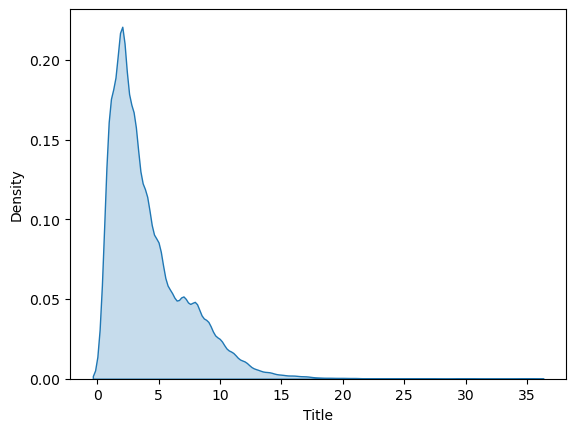

In [10]:
sns.kdeplot(df["Title"].str.split().str.len(), fill = True)

In [11]:
# Group the data by the 'Author' column and calculate the mean of the 'Poetry Foundation ID' column for each group
mean_by_author = df.groupby(['Author'])['Poetry Foundation ID'].mean()

# Create a new column which concatenates all the categorical columns
df["text"] = df["Author"] +" "+ df["Title"] +" "+ df["Content"]

# Tokenize the text
from nltk.tokenize import word_tokenize
df["text"] = df["text"].apply(word_tokenize)

# Flatten the list of words
from itertools import chain
words = list(chain(*df["text"].tolist()))

# Create the word count dictionary
from collections import Counter
word_counts = dict(Counter(words))

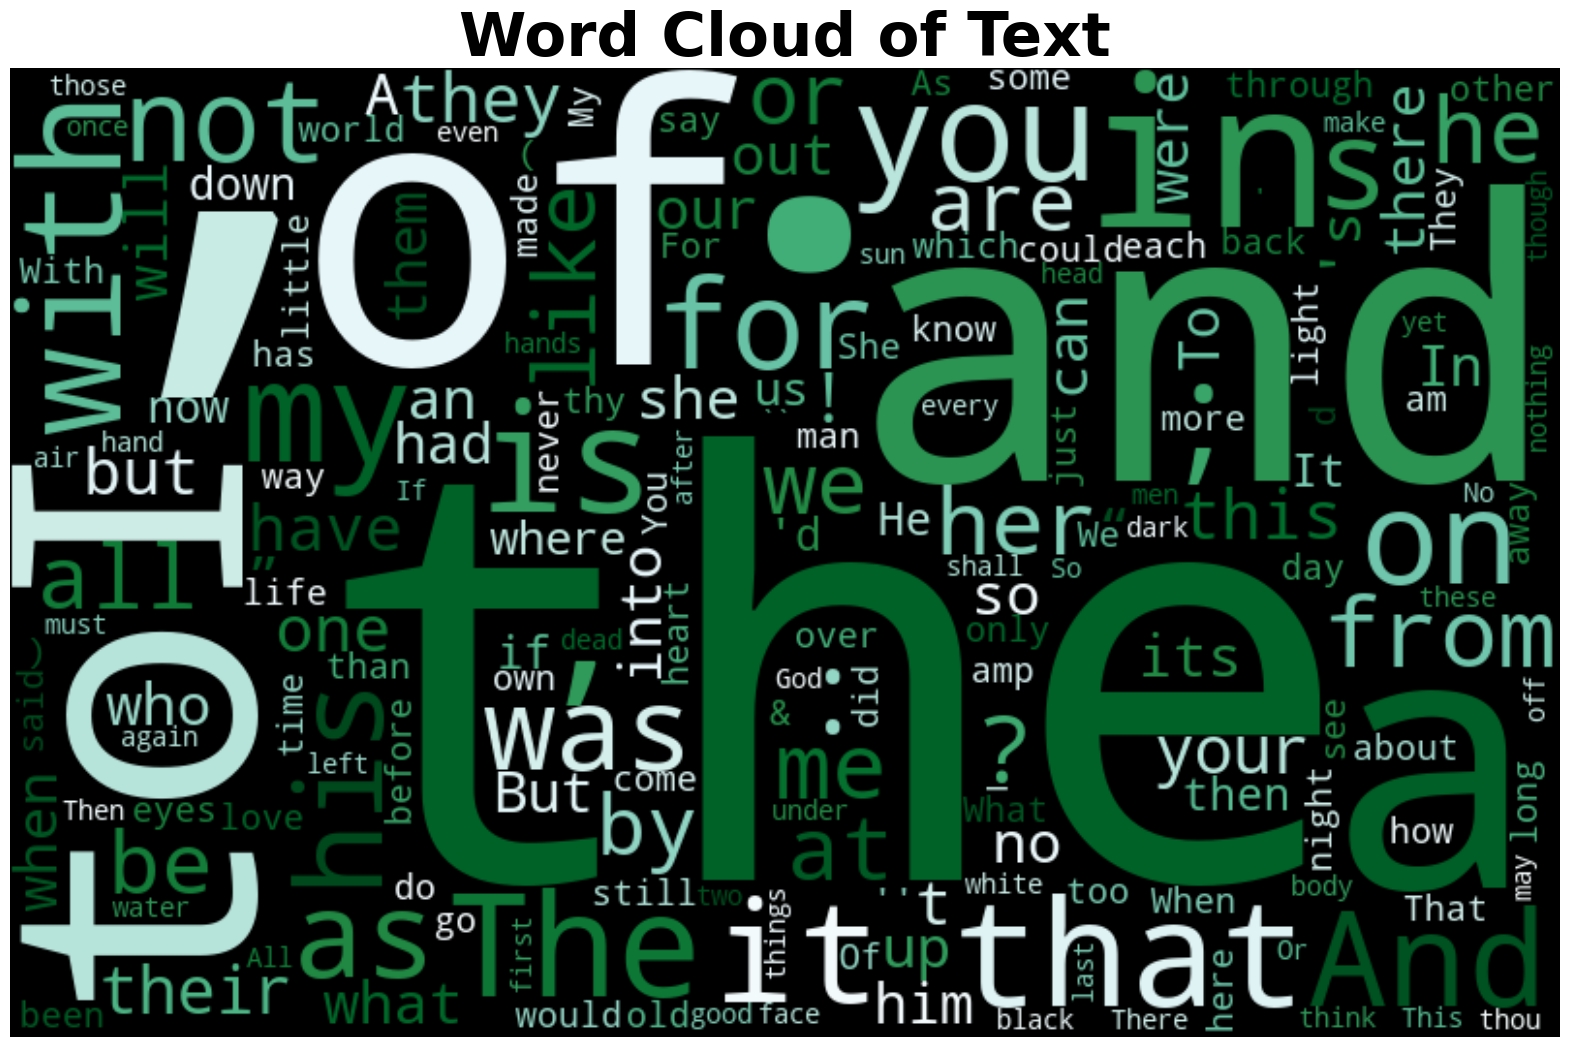

In [12]:
# Create the word cloud object
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', colormap = 'BuGn', 
                      max_words = 200, stopwords = stopwords, contour_width = 3, contour_color = 'black')

# Generate the word cloud
wordcloud.generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize = (20, 20))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Word Cloud of Text", fontsize = 44, fontweight = 'bold')
plt.show()

## Data Preprocessing - Cleaning

In [13]:
# Choosing the columns that I will be using for my poetry generator
poem_df = df[['Content']]
poem_df.head()

,Content
0,"Dear Writers, I’m compiling the first in what ..."
1,"Philosophic\nin its complex, ovoid emptiness,\..."
2,We'd like to talk with you about fear t...
3,The Wise Men will unlearn your name.\nAbove yo...
4,For Jack Collom\n10 Things I do Every Day\n\np...


In [14]:
# Removing special characters and numbers.
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.strip()
    text = "".join(c for c in text if c not in string.punctuation)
    return text

poems = []
for i in range(len(poem_df)):
    poems.append(clean_text(poem_df.iloc[i]['Content']))

In [15]:
# Replacing newline characters
def clean_text(text):
    text = text.replace('\n', ' ')
    return text

poems = []
for i in range(len(poem_df)):
    poems.append(clean_text(poem_df.iloc[i]['Content']))

In [16]:
# Removing extra spaces
def clean_text(text):
    text = text.strip()
    return text

poems = []
for i in range(len(poem_df)):
    poems.append(clean_text(poem_df.iloc[i]['Content']))

In [17]:
print(poem_df[:5]) # print the first 5 rows of the cleaned data
print(len(poem_df)) # print the length of the cleaned data
print(poem_df.isnull().sum()) # check for any missing or null values

                                             Content
0  Dear Writers, I’m compiling the first in what ...
1  Philosophic\nin its complex, ovoid emptiness,\...
2  We'd  like  to  talk  with  you  about  fear t...
3  The Wise Men will unlearn your name.\nAbove yo...
4  For Jack Collom\n10 Things I do Every Day\n\np...
15652
Content    0
dtype: int64


In [18]:
poem_df.duplicated().sum()

14

In [19]:
# Remove duplicate rows
poem_df = poem_df.drop_duplicates()

## Exploratory Data Analysis (EDA)

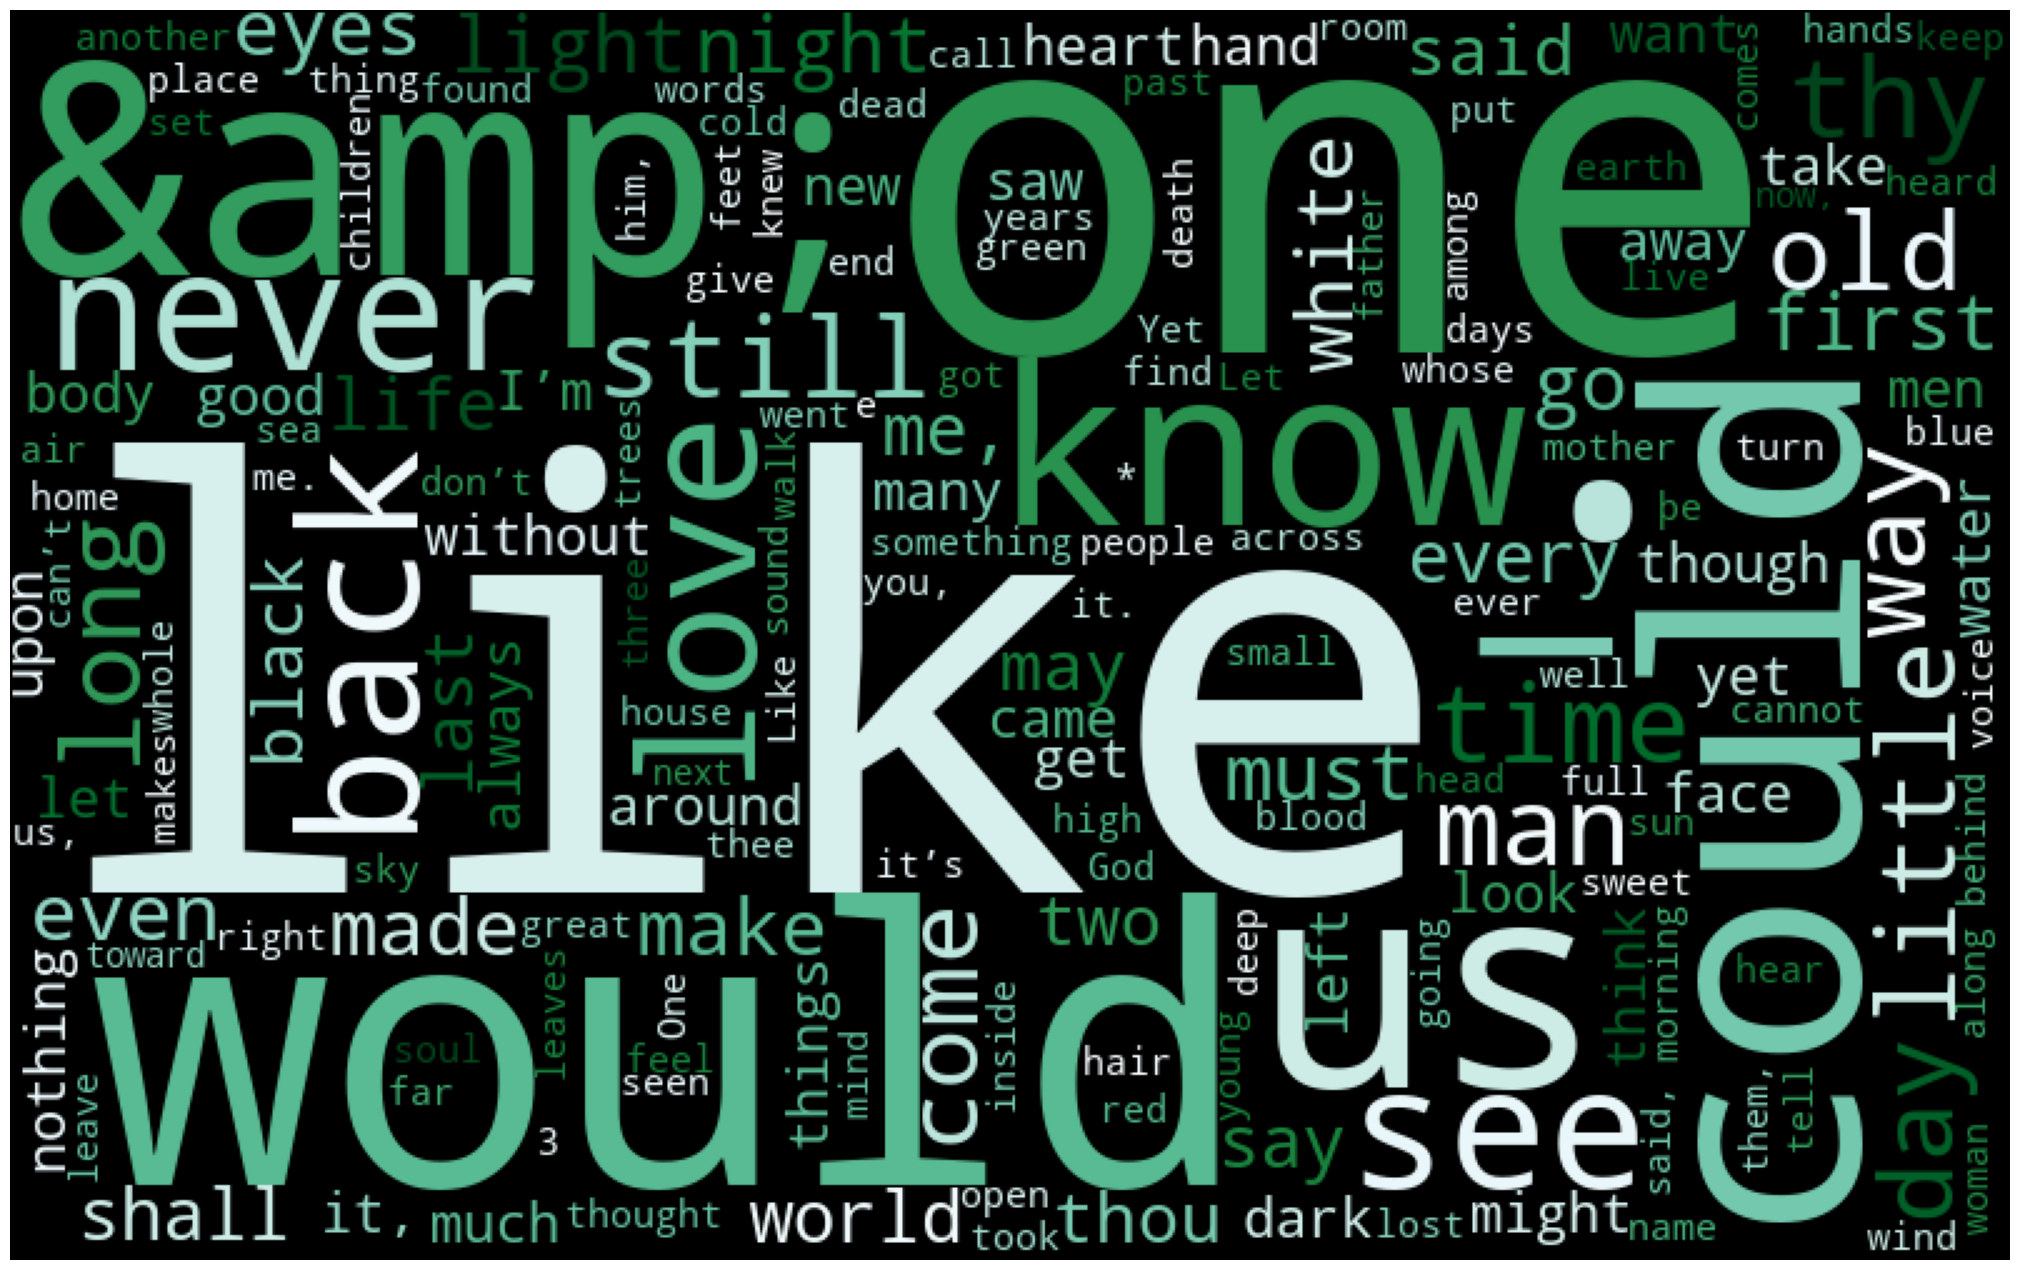

In [20]:
# Create list of all words in the poems
all_words = ' '.join(poem_df['Content']).split()

# Remove stop words from list of words
all_words = [word for word in all_words if word.lower() not in stopwords]

# Count the frequency of each word
fdist = FreqDist(all_words)

# create a word cloud visualization
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='black',
                colormap = 'BuGn', 
                stopwords = stopwords, 
                min_font_size = 12).generate_from_frequencies(fdist)

# Plot the word cloud
plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

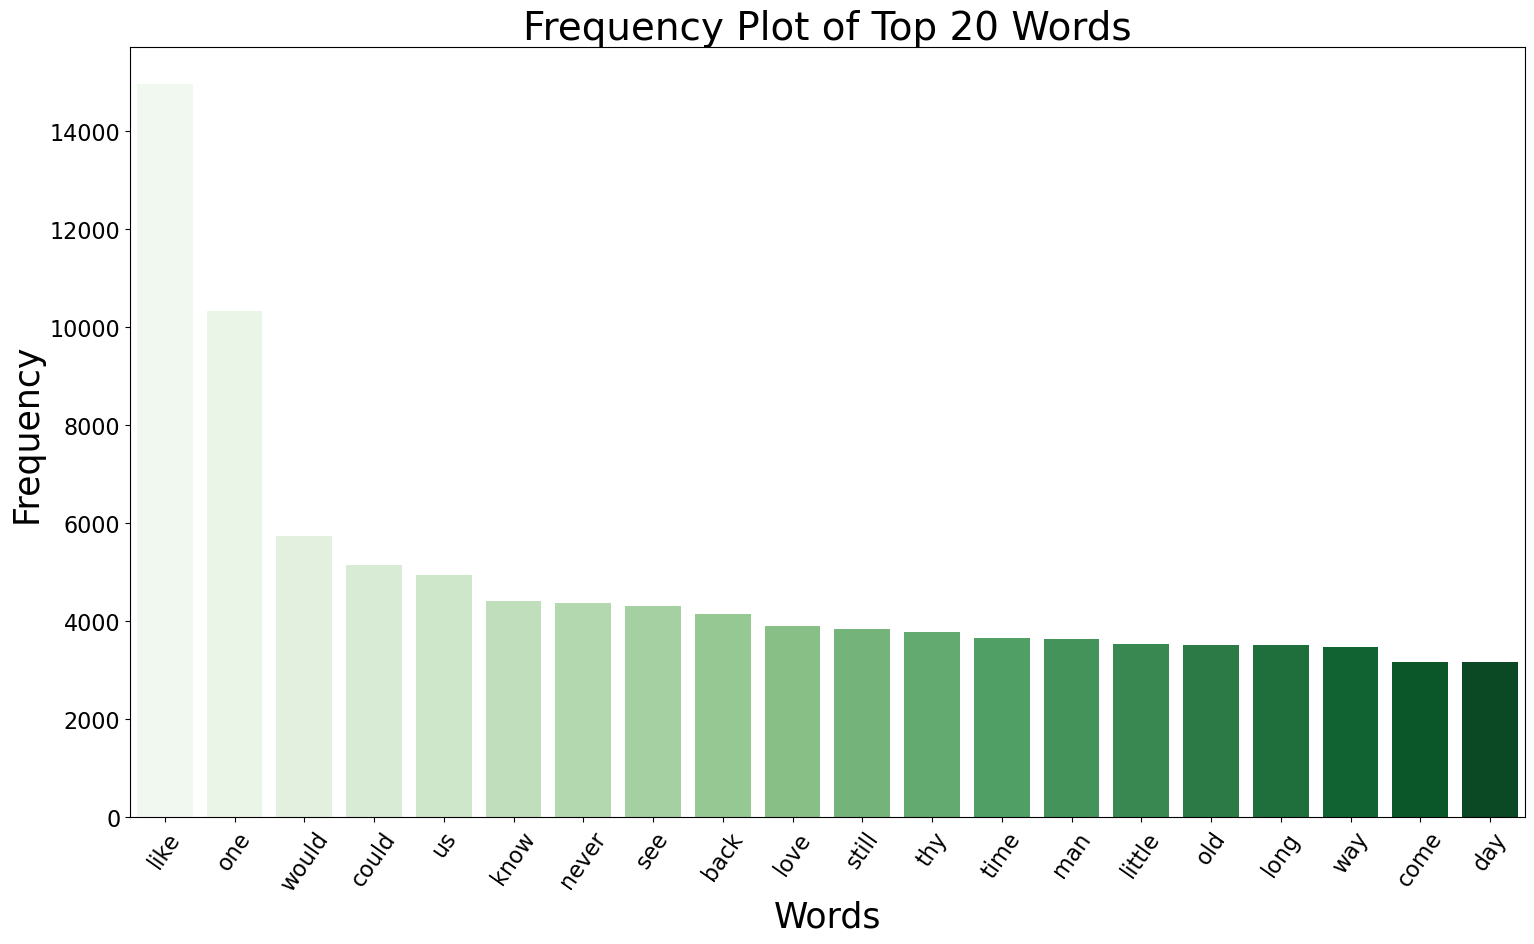

In [21]:
from nltk.corpus import stopwords
# create a list of all the words in the poems
all_words = ' '.join(poem_df['Content']).split()

# remove stop words from list of words
stopwords = set(stopwords.words('english'))
all_words = [word for word in all_words if word.lower() not in stopwords  and word.isalnum()]


# count the frequency of each word
word_freq = Counter(all_words)

# sort the words by frequency
sorted_word_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

# extract the top 20 words and their frequencies
top_20_words = sorted_word_freq[:20]

# create a bar plot of the top 20 words
words = [word for word, freq in top_20_words]
freqs = [freq for word, freq in top_20_words]
plt.figure(figsize = (18,10))
custom_palette = sns.color_palette("Greens", len(words))
sns.barplot(x = words, y = freqs, palette = custom_palette)
plt.xlabel('Words', fontsize = 25)
plt.ylabel('Frequency', fontsize = 25)
plt.title('Frequency Plot of Top 20 Words', fontsize = 28)
plt.xticks(rotation = 55)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()

## Text Preprocessing - Lemmatization & Tokenization

In [22]:
poem_df["Content"] = poem_df["Content"].apply(lambda x: x.lower())

In [23]:
# Removing punctuations 
import string
poem_df["Content"] = poem_df["Content"].apply(lambda x: 
                            [word for word in x if word not in string.punctuation])

In [25]:
# Removing stop words
poem_df["Content"] = poem_df["Content"].apply(lambda x: 
                                [word for word in x if word not in stopwords])


In [27]:
# Tokenization

# Convert non-string elements in the "Content" column to strings
poem_df["Content"] = poem_df["Content"].apply(lambda x: str(x))

# Tokenize the text in the "Content" column
poem_df["Content"] = poem_df["Content"].apply(word_tokenize)

In [28]:
# Lemmatizing
from textblob import Word
poem_df["Content"] = poem_df["Content"].apply(lambda x: [Word(word).lemmatize() for word in x])